In [15]:
# Setting up environment

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import joblib

from sklearn.preprocessing import StandardScaler

from dotenv import load_dotenv

load_dotenv()
mpl.rcParams['figure.figsize'] = (12, 10)

In [16]:
# drop colomn
def dropColomn(df, col):
    try:
        df = df.drop(col,1)
    except:
        print('colomn {0} not found'.format(col))
    return df

# split dataframe to feature target numpy array
def split_feature_label(df):
    return df.iloc[:, :-1].values, df.iloc[:, -1].values

In [17]:
# processing testing dataset

# import dataset
test_df = pd.read_csv('../datasets/sampled_testing.csv')
# drop colomn id
test_df = dropColomn(test_df, 'id')

# split features and labels
x_test, y_test = split_feature_label(test_df)

print('shape of testing feature: {0}'.format(x_test.shape))
print('shape of testing labels: {0}'.format(y_test.shape))

colomn id not found
shape of testing feature: (386, 14)
shape of testing labels: (386,)


In [18]:
# processing training dataset
# import dataset
dataset = pd.read_csv('../datasets/sampled_dataset.csv')

# drop colomm id
dataset = dropColomn(dataset, 'id')

print(dataset.TenYearCHD.value_counts())

# split features and labels
x,y = split_feature_label(dataset)

print('shape of training feature: {0}'.format(x.shape))
print('shape of training labels: {0}'.format(y.shape))


1.0    3401
0.0    3387
Name: TenYearCHD, dtype: int64
shape of training feature: (6788, 14)
shape of training labels: (6788,)


In [19]:
dataset.head()

,sex,age,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,214.146341,107.500000,70.000000,23.925366,73.785714,78.555556,0.0
1,0.0,51.0,1.0,20.0,0.0,0.0,0.0,0.0,249.118881,139.500000,89.000000,25.691793,75.821918,79.984615,1.0
2,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,243.803738,124.464644,79.292884,26.812315,74.681818,86.000000,1.0
3,0.0,38.0,1.0,9.0,0.0,0.0,0.0,0.0,215.202797,118.000000,75.000000,25.163986,76.631944,76.753846,0.0
4,1.0,48.0,1.0,25.0,0.0,0.0,1.0,0.0,232.582353,144.000000,79.000000,25.699942,76.028902,79.152866,0.0


In [20]:
# split to training and validating dataset
from sklearn.model_selection import train_test_split

TESTSIZE = float(os.getenv('VALRATE'))
TESTRANDOMSTATE = int(os.getenv('VALRANDOMSTATE'))

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = TESTSIZE, random_state = TESTRANDOMSTATE)

print('shape of training feature: {0}'.format(x_train.shape))
print('shape of training labels: {0}'.format(y_train.shape))

print('shape of validation feature: {0}'.format(x_val.shape))
print('shape of validation labels: {0}'.format(y_val.shape))


shape of training feature: (5091, 14)
shape of training labels: (5091,)
shape of validation feature: (1697, 14)
shape of validation labels: (1697,)


In [21]:
# Scaling data using standar scaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)
x_test = sc.transform(x_test)

# save scaler variable into file
scaler_filename = '../model/scaler.save'
joblib.dump(sc, scaler_filename) 


['../model/scaler.save']

In [22]:
# building model

BATCH_SIZE = int(os.getenv('BATCHSIZE'))
EPOCHS = 300

METRICS = [
    # keras.metrics.TruePositives(name='tp'),
    # keras.metrics.FalsePositives(name='fp'),
    # keras.metrics.TrueNegatives(name='tn'),
    # keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    # keras.metrics.AUC(name='auc'),
    # keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS ):
    model = keras.Sequential([
        keras.layers.Dense(
            14, activation='relu',
            input_shape=(x_train.shape[-1],)),
        keras.layers.Dense(
            64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=32,
    mode='max',
    restore_best_weights=True)

In [23]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                960       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,235
Trainable params: 1,235
Non-trainable params: 0
_________________________________________________________________


In [24]:
zero_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val))

Epoch 1/300
80/80 [==============================] - 2s 9ms/step - loss: 0.6229 - accuracy: 0.6482 - precision: 0.6729 - recall: 0.5792 - val_loss: 0.5919 - val_accuracy: 0.6942 - val_precision: 0.6832 - val_recall: 0.7274
Epoch 2/300
80/80 [==============================] - 0s 2ms/step - loss: 0.5975 - accuracy: 0.6694 - precision: 0.6597 - recall: 0.7024 - val_loss: 0.5845 - val_accuracy: 0.6836 - val_precision: 0.6554 - val_recall: 0.7779
Epoch 3/300
80/80 [==============================] - 0s 2ms/step - loss: 0.5879 - accuracy: 0.6794 - precision: 0.6578 - recall: 0.7502 - val_loss: 0.5779 - val_accuracy: 0.6983 - val_precision: 0.6805 - val_recall: 0.7509
Epoch 4/300
80/80 [==============================] - 0s 2ms/step - loss: 0.5811 - accuracy: 0.6891 - precision: 0.6742 - recall: 0.7337 - val_loss: 0.5718 - val_accuracy: 0.7060 - val_precision: 0.6892 - val_recall: 0.7532
Epoch 5/300
80/80 [==============================] - 0s 2ms/step - loss: 0.5746 - accuracy: 0.6940 - precisi

In [25]:
model.save('../model/ann_model/')

INFO:tensorflow:Assets written to: ../model/ann_model/assets


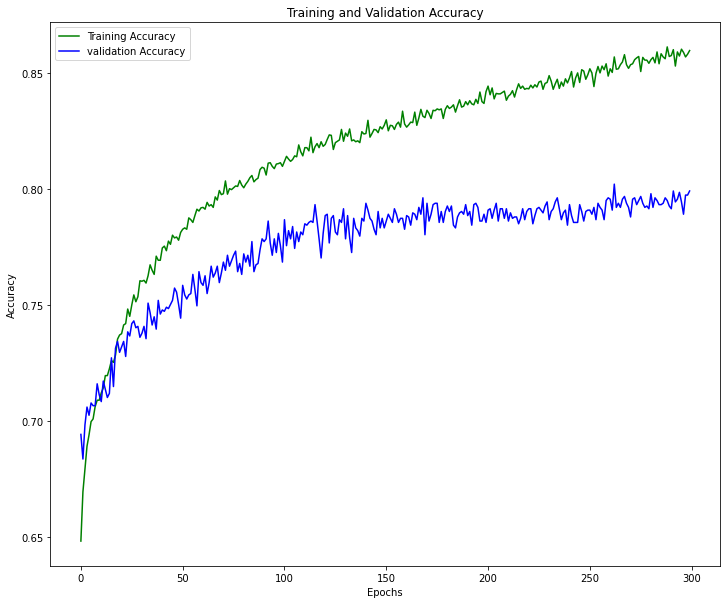

In [26]:
loss_train = zero_bias_history.history['accuracy']
loss_val = zero_bias_history.history['val_accuracy']
epochs = range(len(zero_bias_history.history['accuracy']))
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

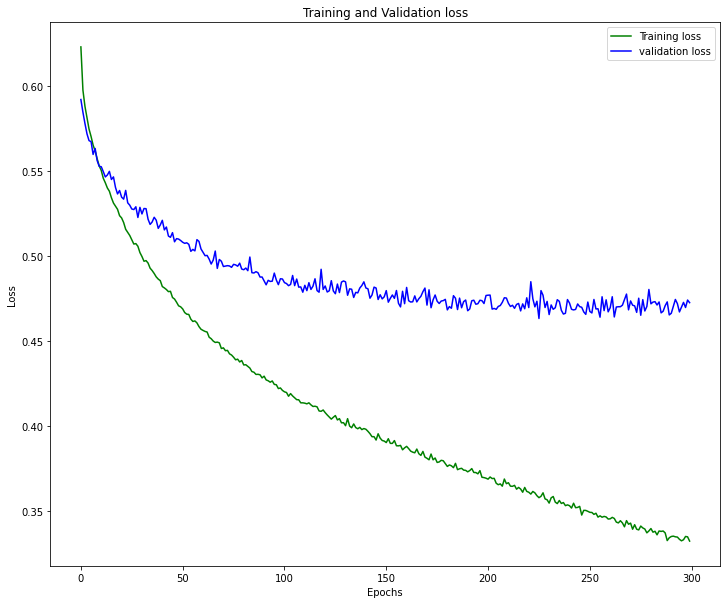

In [27]:
loss_train = zero_bias_history.history['loss']
loss_val = zero_bias_history.history['val_loss']
epochs = range(len(zero_bias_history.history['loss']))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): {0}, with percentage : {1}'.format(cm[0][0], cm[0][0]/len(labels)))
    print('Legitimate Transactions Incorrectly Detected (False Positives): {0}, with percentage : {1}'.format(cm[0][1], cm[0][1]/len(labels)))
    print('Fraudulent Transactions Missed (False Negatives): {0}, with percentage : {1}'.format(cm[1][0], cm[1][0]/len(labels)))
    print('Fraudulent Transactions Detected (True Positives): {0}, with percentage : {1}'.format(cm[1][1], cm[1][1]/len(labels)))
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

    print('Accuracy : ', accuracy_score(labels, predictions > p))
    print('Recall : ', recall_score(labels, predictions > p))
    print('Precision : ', precision_score(labels, predictions > p))

[[8.94439220e-01 1.00000000e+00]
 [2.23489106e-02 0.00000000e+00]
 [4.32660431e-01 1.00000000e+00]
 [3.81309390e-02 0.00000000e+00]
 [8.62255335e-01 1.00000000e+00]
 [3.06772500e-01 1.00000000e+00]
 [9.91014898e-01 1.00000000e+00]
 [3.32837999e-01 1.00000000e+00]
 [1.31232738e-01 1.00000000e+00]
 [4.84354198e-01 0.00000000e+00]
 [3.15591693e-03 0.00000000e+00]
 [8.67802203e-02 1.00000000e+00]
 [1.58805847e-02 1.00000000e+00]
 [9.80172992e-01 1.00000000e+00]
 [9.86267507e-01 1.00000000e+00]
 [8.37430954e-02 0.00000000e+00]
 [5.78066945e-01 0.00000000e+00]
 [7.80225515e-01 0.00000000e+00]
 [6.95094824e-01 1.00000000e+00]
 [2.09515840e-01 1.00000000e+00]
 [1.60749435e-01 1.00000000e+00]
 [1.93323940e-01 0.00000000e+00]
 [1.08970046e-01 0.00000000e+00]
 [9.17417288e-01 1.00000000e+00]
 [8.52432728e-01 1.00000000e+00]
 [9.33529735e-01 1.00000000e+00]
 [4.10006046e-02 0.00000000e+00]
 [5.02651691e-01 0.00000000e+00]
 [9.08628702e-02 0.00000000e+00]
 [1.04571968e-01 1.00000000e+00]
 [7.699406

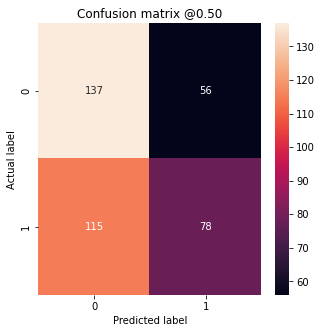

In [29]:
# predicting test data
y_pred = model.predict(x_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
plot_cm(y_test, y_pred)

[[8.56742501e-01 1.00000000e+00]
 [3.57349694e-01 0.00000000e+00]
 [3.45511436e-02 0.00000000e+00]
 ...
 [1.35795781e-05 0.00000000e+00]
 [1.01904452e-01 1.00000000e+00]
 [1.53184533e-02 0.00000000e+00]]
Legitimate Transactions Detected (True Negatives): 648, with percentage : 0.38185032410135533
Legitimate Transactions Incorrectly Detected (False Positives): 198, with percentage : 0.11667648791985857
Fraudulent Transactions Missed (False Negatives): 143, with percentage : 0.08426635238656452
Fraudulent Transactions Detected (True Positives): 708, with percentage : 0.41720683559222155
Total Fraudulent Transactions:  851
Accuracy :  0.7990571596935769
Recall :  0.8319623971797885
Precision :  0.7814569536423841


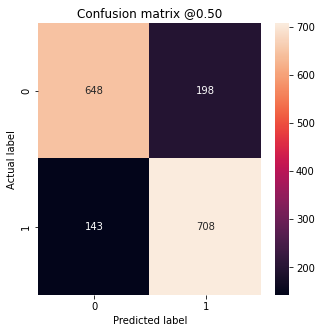

In [30]:
# conf matrix on validation data

y_pred = model.predict(x_val)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_val.reshape(len(y_val),1)),1))

plot_cm(y_val, y_pred)

In [31]:
# merged final test df with result
result = pd.DataFrame((y_pred.reshape(
    len(y_pred), 1) > 0.5), columns=['predicted'])
pd.concat([test_df, result], axis=1)[:20]


,sex,age,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,predicted
0,0.0,67.0,0.0,0.0,0.0,0.0,1.0,0.0,251.547619,147.0,92.0,26.297556,76.266667,89.829268,1.0,True
1,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,225.430380,127.0,79.5,25.289057,77.603774,80.842857,0.0,False
2,1.0,42.0,1.0,20.0,0.0,0.0,0.0,0.0,227.655556,110.0,80.0,25.273333,75.522222,77.119760,1.0,False
3,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,217.508021,122.0,78.0,24.993351,76.518325,78.436782,0.0,False
4,0.0,59.0,1.0,10.0,1.0,0.0,1.0,0.0,254.898305,175.0,82.0,26.463782,74.705882,84.102804,1.0,True
5,1.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,254.898305,131.5,84.0,26.463782,74.705882,84.102804,1.0,True
6,0.0,57.0,1.0,43.0,0.0,0.0,1.0,0.0,247.829268,207.5,118.0,26.783984,75.276423,82.067797,1.0,True
7,1.0,62.0,0.0,0.0,0.0,0.0,1.0,0.0,256.123711,156.0,91.0,26.926061,74.454545,92.763441,1.0,False
8,1.0,50.0,0.0,0.0,0.0,0.0,1.0,1.0,241.145985,148.5,94.0,25.941571,76.457143,82.267717,1.0,False
9,0.0,64.0,0.0,0.0,0.0,0.0,1.0,0.0,248.521739,206.0,104.0,25.987473,76.706522,85.170455,0.0,True
